The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


# Pretraining BERT

*This section is under construction.*

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx

npx.set_np()

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## Training BERT

In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256,
                    num_heads=2, num_layers=2, dropout=0.2)
ctx = d2l.try_all_gpus()
net.initialize(init.Xavier(), ctx=ctx)
loss = gluon.loss.SoftmaxCELoss()

...

In [4]:
# Saved in the d2l package for later use
def _get_batch_bert(batch, ctx):
    (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) = batch
    split_and_load = gluon.utils.split_and_load
    return (split_and_load(tokens_X, ctx, even_split=False),
            split_and_load(segments_X, ctx, even_split=False),
            split_and_load(valid_lens_x.astype('float32'), ctx,
                           even_split=False),
            split_and_load(pred_positions_X, ctx, even_split=False),
            split_and_load(mlm_weights_X, ctx, even_split=False),
            split_and_load(mlm_Y, ctx, even_split=False),
            split_and_load(nsp_y, ctx, even_split=False))

...

In [5]:
# Saved in the d2l package for later use
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
         pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
         nsp_y_shard) in zip(
        tokens_X_shards, segments_X_shards, valid_lens_x_shards,
        pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
        nsp_y_shards):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = net(
            tokens_X_shard, segments_X_shard, valid_lens_x_shard.reshape(-1),
            pred_positions_X_shard)
        # Compute masked language model loss
        mlm_l = loss(
            mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shard.reshape(-1),
            mlm_weights_X_shard.reshape((-1, 1)))
        mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = loss(nsp_Y_hat, nsp_y_shard)
        nsp_l = nsp_l.mean()
        mlm_ls.append(mlm_l)
        nsp_ls.append(nsp_l)
        ls.append(mlm_l + nsp_l)
        npx.waitall()
    return mlm_ls, nsp_ls, ls

...

In [6]:
# Saved in the d2l package for later use
def train_bert(train_iter, net, loss, vocab_size, ctx, log_interval,
               num_steps):
    trainer = gluon.Trainer(net.collect_params(), 'adam')
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # MLM loss, NSP loss, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards,
             mlm_Y_shards, nsp_y_shards) = _get_batch_bert(batch, ctx)
            timer.start()
            with autograd.record():
                mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                    valid_lens_x_shards, pred_positions_X_shards,
                    mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step(1)
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            if (step + 1) % log_interval == 0:
                animator.add(step + 1,
                             (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print('MLM loss %.3f, NSP loss %.3f'
          % (metric[0] / metric[3], metric[1] / metric[3]))
    print('%.1f sentence pairs/sec on %s' % (metric[2] / timer.sum(), ctx))

...

MLM loss 7.911, NSP loss 0.812
9614.2 sentence pairs/sec on [gpu(0), gpu(1)]


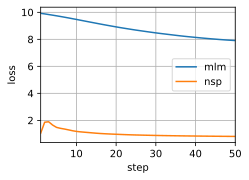

In [7]:
train_bert(train_iter, net, loss, len(vocab), ctx, 1, 50)

## Representing text with BERT

In [8]:
def get_bert_encoding(bert, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    ctx = npx.gpu(0)
    token_ids = np.expand_dims(np.array(vocab[tokens], ctx=ctx), axis=0)
    segments = np.expand_dims(np.array(segments, ctx=ctx), axis=0)
    valid_len = np.expand_dims(np.array(len(tokens), ctx=ctx), axis=0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [9]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

((1, 6, 128),
 (1, 128),
 array([-0.74203193,  0.7830542 , -0.6265218 ], ctx=gpu(0)))

In [10]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

((1, 10, 128),
 (1, 128),
 array([-0.75613534,  0.7656936 , -0.5770142 ], ctx=gpu(0)))

## Exercises

1. Why MLM loss is significantly higher than NSP loss?